In [1]:
from models import NetworkedRENs, REN, RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from os.path import dirname, join as pjoin
import torch
from torch import nn

In [2]:
dtype = torch.float
device = torch.device("cpu")

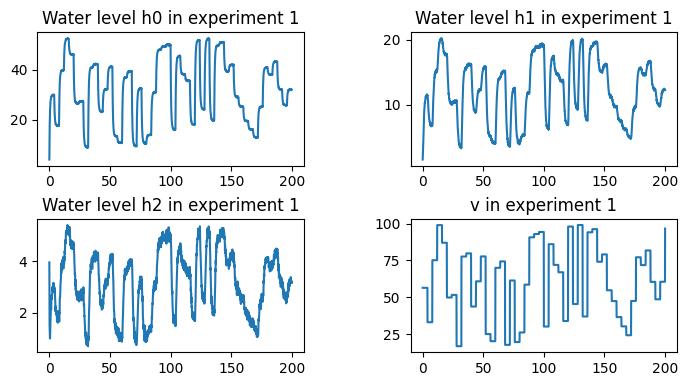

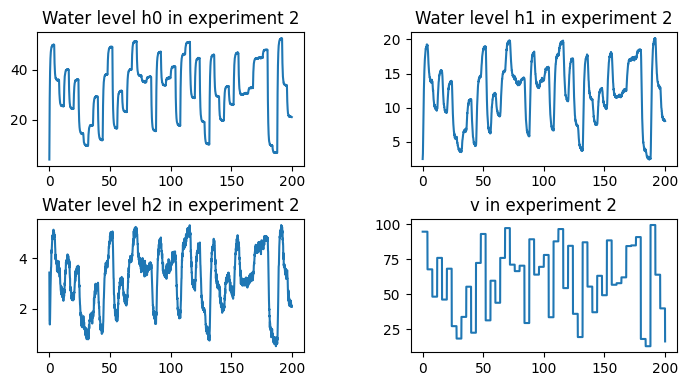

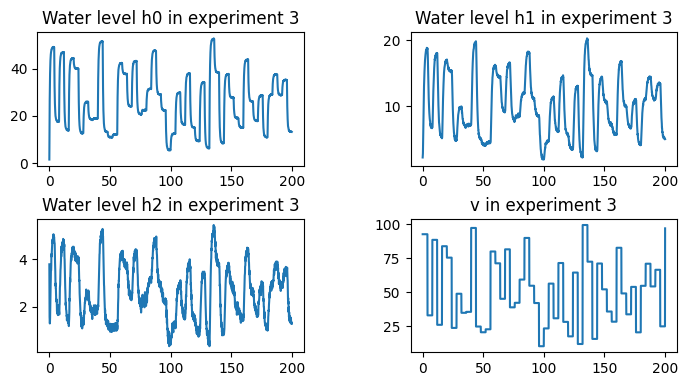

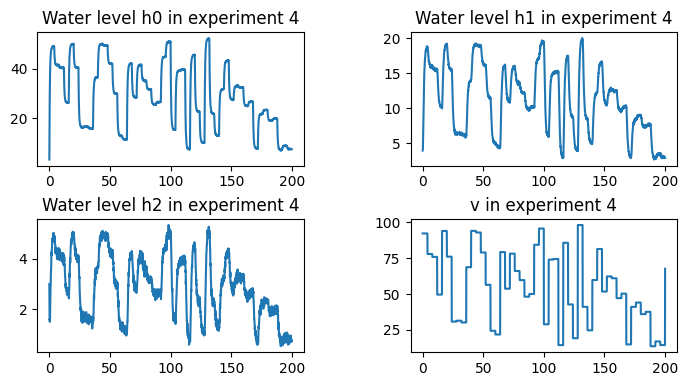

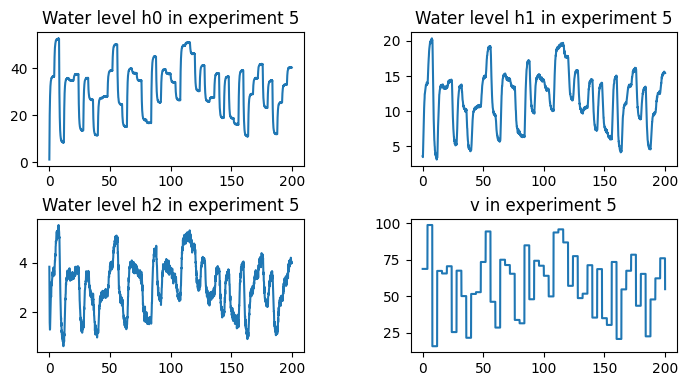

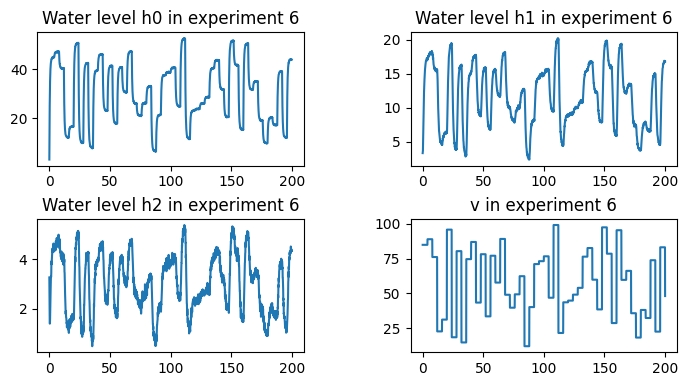

In [3]:
# Import Data
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'dataset_sysID_3tanks.mat')
data = scipy.io.loadmat(filepath)

dExp, yExp, dExp_val, yExp_val, Ts = data['dExp'], data['yExp'], \
    data['dExp_val'], data['yExp_val'], data['Ts'].item()
nExp = yExp.size

ny = np.shape(yExp[0,-1])[0]
nd = np.shape(dExp[0,-1])[0]

t = np.arange(0, np.size(dExp[0, 0], 1) * Ts-Ts, Ts)
t_end = yExp[0, 0].shape[1] - 1

for exp in range(nExp):
    y_exp = yExp[0,exp]
    d_exp = dExp[0,exp]
    plt.figure(figsize=(4 * 2, 4))
    for out in range(ny):
        plt.subplot(2, 2, out+1)
        plt.plot(t, y_exp[out,:])
        plt.title(r"Water level h%i "%out + r"in experiment %i"%(exp+1))
    plt.subplot(2, 2, ny+1)
    plt.plot(t, d_exp[1,:])
    plt.title(r"v in experiment %i"%(exp+1))
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.show()

Epoch: 1 	||	 Loss: 414.3548278808594
Epoch: 2 	||	 Loss: 392.72479248046875
Epoch: 3 	||	 Loss: 331.20556640625
Epoch: 4 	||	 Loss: 203.9366912841797
Epoch: 5 	||	 Loss: 102.04927062988281
Epoch: 6 	||	 Loss: 98.8807601928711
Epoch: 7 	||	 Loss: 42.4819450378418
Epoch: 8 	||	 Loss: 55.348915100097656
Epoch: 9 	||	 Loss: 36.29169845581055
Epoch: 10 	||	 Loss: 5.291676044464111
Epoch: 11 	||	 Loss: 28.0578556060791
Epoch: 12 	||	 Loss: 20.347009658813477
Epoch: 13 	||	 Loss: 4.018519401550293
Epoch: 14 	||	 Loss: 17.718019485473633
Epoch: 15 	||	 Loss: 24.17389678955078
Epoch: 16 	||	 Loss: 15.967557907104492
Epoch: 17 	||	 Loss: 8.277503967285156
Epoch: 18 	||	 Loss: 17.521190643310547
Epoch: 19 	||	 Loss: 18.744102478027344
Epoch: 20 	||	 Loss: 8.249536514282227
Epoch: 21 	||	 Loss: 9.28199291229248
Epoch: 22 	||	 Loss: 13.113207817077637
Epoch: 23 	||	 Loss: 10.21096420288086
Epoch: 24 	||	 Loss: 4.046525001525879
Epoch: 25 	||	 Loss: 4.9363694190979
Epoch: 26 	||	 Loss: 7.0982232093

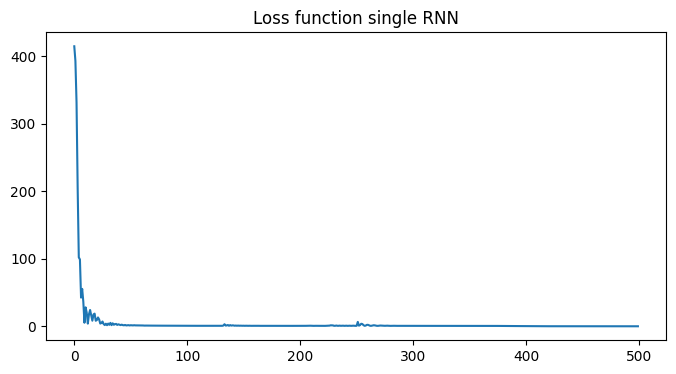

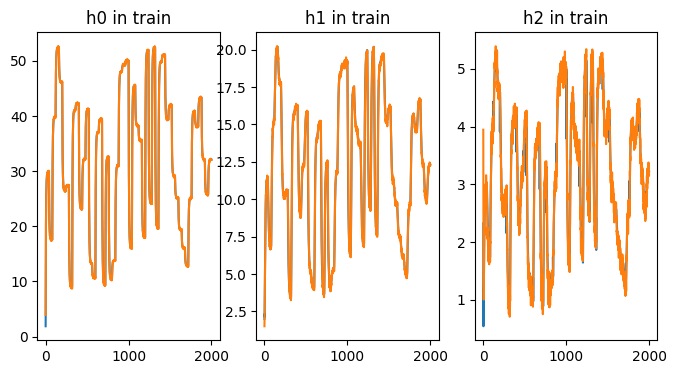

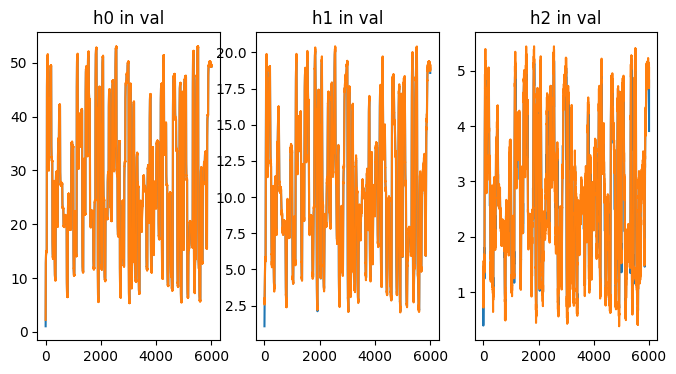

Loss Validation single RNN: 0.07348696142435074


In [4]:
# Train single RNN
epochs = 500
n = 1  # input dimensions
inputnumberD = 1
p = ny  # output dimensions

u = torch.zeros(nExp, t_end+1, n)
y = torch.zeros(nExp, t_end+1, p)

for j in range(nExp):
    inputActive = (torch.from_numpy(dExp[0, j])).T
    u[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    y[j, :, :] = (torch.from_numpy(yExp[0, j])).T


idd = 1
hdd = 20
ldd = 5
odd = yExp[0, 0].shape[0]

RNN = RNNModel(idd, hdd, ldd, odd)
MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    lossRNN = 0

    yRNN = RNN(u)
    yRNN = torch.squeeze(yRNN)
    lossRNN = MSE(yRNN, y)
    lossRNN.backward()
    optimizer.step()
    print(f"Epoch: {epoch + 1} \t||\t Loss: {lossRNN}")
    LOSS[epoch] = lossRNN

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single RNN")
plt.show()

# Validation
t_end_v = yExp_val[0, 0].shape[1]

nExp_val = yExp_val.size

uval = torch.zeros(nExp_val, t_end_v, 1)
yval = torch.zeros(nExp_val, t_end_v, 3)

for j in range(nExp_val):
    inputActive = (torch.from_numpy(dExp_val[0, j])).T
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j])).T

yRNN_val = RNN(uval)
yRNN_val = torch.squeeze(yRNN_val)

loss_val_RNN = MSE(yRNN_val, torch.squeeze(yval))

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRNN[0,0:t_end,out].detach().numpy(), label='RNN train')
    plt.plot(y[0, 0:t_end,out].detach().numpy(), label='y train')
    plt.title(r"h%i "%out + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRNN_val[0:t_end_v,out].detach().numpy(), label='RNN val')
    plt.plot(yval[0, 0:t_end_v,out].detach().numpy(), label='y val')
    plt.title(r"h%i "%out + r"in val")  
plt.show()

pytorch_total_params_singleRNN = sum(p.numel() for p in RNN.parameters() if p.requires_grad)
print(f"Loss Validation single RNN: {loss_val_RNN}")

Epoch: 1 	||	 Loss: 249.02684020996094
L2 gain REN: 0.1600000113248825
Epoch: 2 	||	 Loss: 182.5939483642578
L2 gain REN: 0.25006556510925293
Epoch: 3 	||	 Loss: 109.66875457763672
L2 gain REN: 0.3603900969028473
Epoch: 4 	||	 Loss: 56.05024719238281
L2 gain REN: 0.48873525857925415
Epoch: 5 	||	 Loss: 19.923791885375977
L2 gain REN: 0.6244909167289734
Epoch: 6 	||	 Loss: 14.354499816894531
L2 gain REN: 0.7357714772224426
Epoch: 7 	||	 Loss: 44.27099609375
L2 gain REN: 0.7845058441162109
Epoch: 8 	||	 Loss: 65.27485656738281
L2 gain REN: 0.7751514911651611
Epoch: 9 	||	 Loss: 57.65351486206055
L2 gain REN: 0.7302659153938293
Epoch: 10 	||	 Loss: 35.668670654296875
L2 gain REN: 0.66893470287323
Epoch: 11 	||	 Loss: 15.624465942382812
L2 gain REN: 0.606163740158081
Epoch: 12 	||	 Loss: 9.812239646911621
L2 gain REN: 0.5536391139030457
Epoch: 13 	||	 Loss: 15.293205261230469
L2 gain REN: 0.51596599817276
Epoch: 14 	||	 Loss: 19.11966896057129
L2 gain REN: 0.49294665455818176
Epoch: 15 	||

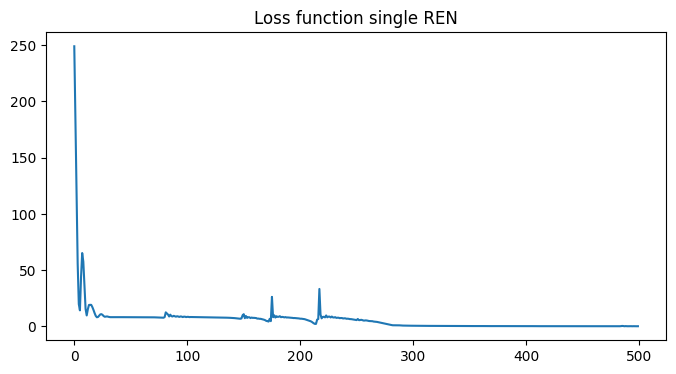

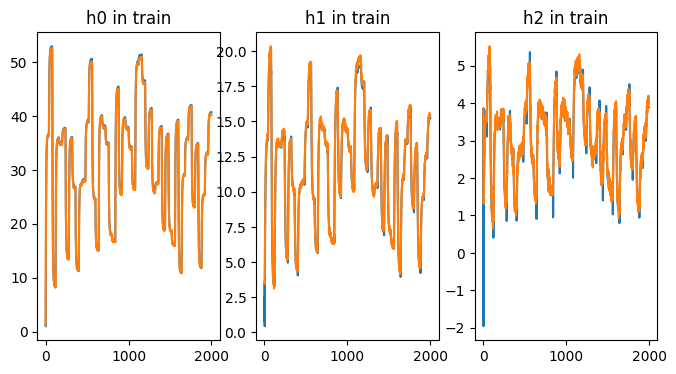

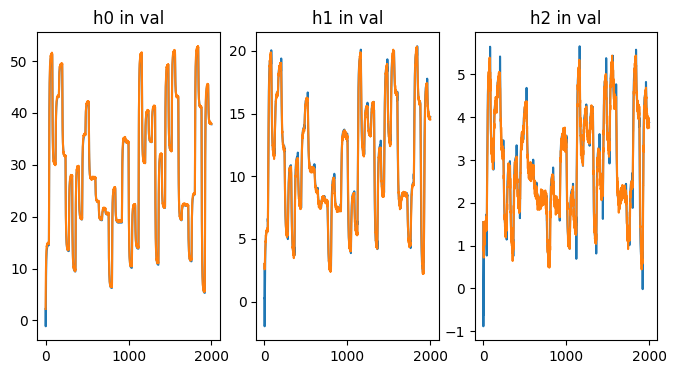

Loss Validation single REN: 0.403641939163208


In [5]:
# Train single REN
epochs = 500

n = 1  # input dimensions
inputnumberD = 1
p = ny  # output dimensions

n_xi = 20# nel paper n1, numero di stati
l = 20  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE
# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = True)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp - 1):
        y = torch.from_numpy(yExp[0, exp]).float().to(device)
        y = y.squeeze()
        yRENm = torch.randn(p, t_end + 1, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)
        d = torch.from_numpy(dExp[0, exp]).float().to(device)
        for t in range(1, t_end):
            u = torch.tensor([d[inputnumberD, t]])
            yRENm[:, t], xi = RENsys(u, xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss / nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN")
plt.show()

yval = torch.from_numpy(yExp_val[0, 0]).float().to(device)
yval = yval.squeeze()

yRENm_val = torch.zeros(p, t_end + 1, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.from_numpy(dExp_val[0, 0]).float().to(device)
loss_val = 0
for t in range(1, t_end):
    u = torch.tensor([dval[inputnumberD, t]])
    yRENm_val[:, t], xiVal = RENsys(u, xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

loss_val_REN = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm[out, 0:t_end].detach().numpy(), label='REN train')
    plt.plot(y[out, 0:t_end].detach().numpy(), label='y train')
    plt.title(r"h%i "%out + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm_val[out, 0:t_end].detach().numpy(), label='REN val')
    plt.plot(yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title(r"h%i "%out + r"in val")  
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN: {loss_val_REN}")

In [ ]:
# TRAIN OF NETWORKED RENs
epochs = 400

torch.manual_seed(2)
N = 3 # Number of interconnected systems

n = torch.tensor([2, 1, 1])  # input dimensions
p = torch.tensor([1, 1, 1])  # output dimensions

n_xi = np.array([10, 10, 10]) # nel paper n1, numero di stati
l = np.array([10, 10, 10])  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

Muy = torch.tensor([[0, 0, 1], [0, 0, 0], [1, 0, 0], [0, 1, 0]])
Muy = Muy.float()

Mud = torch.eye(n.sum())
Mey = torch.eye(p.sum())

# Define the system
RENsys = NetworkedRENs(N, Muy, Mud, Mey, n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)
loss = 0

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp - 1):
        xi = []
        y = torch.from_numpy(yExp[0, exp]).float().to(device)
        y = y.squeeze()
        yRENm = torch.randn(3, t_end + 1, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        for j in range(N):
            xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
        d = torch.from_numpy(dExp[0, exp]).float().to(device)
        xi = torch.cat(xi)
        for t in range(1, t_end):
            yRENm[:, t], xi = RENsys(t, d[:, t - 1], xi)

        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss / nExp
    loss.backward()
    # loss.backward(retain_graph=True)

    optimizer.step()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    for net in range(N):
        print(f"L2 gain REN%i"%net+":%.1f"%RENsys.r[net].gamma)
    LOSS[epoch] = loss

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function")
plt.show()

# Validation
xi = []
y = torch.from_numpy(yExp[0, 0]).float().to(device)
y = y.squeeze()
yRENm = torch.zeros(3, t_end + 1, device=device, dtype=dtype)
yRENm[:,0] = y[:,0]
for j in range(N):
    xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
dtrain = torch.from_numpy(dExp[0, 0]).float().to(device)
xi = torch.cat(xi)
for t in range(1, t_end):
    yRENm[:, t], xi = RENsys(t, dtrain[:, t - 1], xi)


t_end = yExp_val[0, 0].shape[1] - 1
xiVal =[]
yval = torch.from_numpy(yExp_val[0, 0]).float().to(device)
yval = yval.squeeze()
yRENm_val = torch.zeros(3, t_end + 1, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
for j in range(N):
    xiVal.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
dval = torch.from_numpy(dExp_val[0, 0]).float().to(device)
xiVal = torch.cat(xiVal)
loss_val = 0
for t in range(1, t_end):
    yRENm_val[:, t], xiVal = RENsys(t, dval[:, t - 1], xiVal)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm[out, 0:t_end].detach().numpy(), label='networked REN train')
    plt.plot(y[out, 0:t_end].detach().numpy(), label='y train')
    plt.title(r"h%i"%out + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm_val[out, 0:t_end].detach().numpy(), label='networked REN val')
    plt.plot(yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title(r"h%i\n"%out + r"in val")  
plt.show()

pytorch_total_params_3RENs = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)

print(f"param networked RENs: {pytorch_total_params_3RENs}")
print(f"param single REN: {pytorch_total_params_singleREN}")
print(f"param single REN: {pytorch_total_params_singleRNN}")


print(f"Loss Validation networked RENs: {loss_val}")